### Importing our own functions

In [1]:
import importlib

import src.Data as Data
importlib.reload(Data)
Data = Data.Data

import src.Metrics as Metrics
importlib.reload(Metrics)
Metrics = Metrics.Metrics

### Importing libraries
`numpy` and `pandas` are used to manipulate the data

`scikit-learn` is used to train the classification models and compute the metrics

`matplotlib` and `seaborn` are used to plot the results

In [2]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import LearningCurveDisplay, learning_curve, cross_validate, train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd

### Loading the data
The data is loaded from the `data` folder.

Samples are split into a training set and a test set with a custom ratio. Stratified sampling is used to ensure that the proportion of samples in each class is the same in both sets.

Images are resized to a custom size so that all images have the same dimensions. Therefor, some leaves appear smaller than others.

In [4]:
data: Data = Data(test_size=0.2, include_images=True)

### Visualizing the data
Here are some examples of images in the dataset:

Leafs speacies from the dataset : 


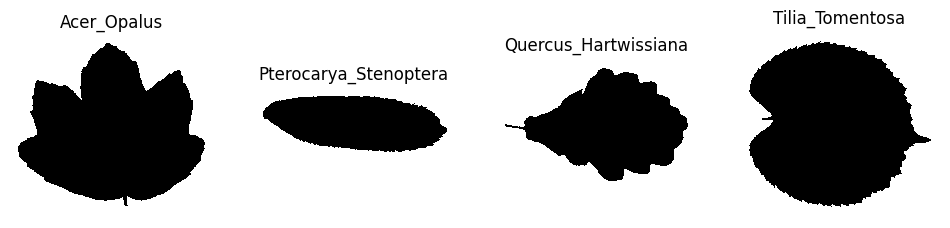

In [5]:
print('Leafs speacies from the dataset : ')
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for ax, image, label in zip(axes, data.x_image_tab, data.y_tab):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f'{label}')

### Choosing a model and training it

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Creating a classifier: a support vector classifier
# clf = svm.SVC(gamma=0.001)
clf = RandomForestClassifier(n_jobs=-1)
# clf = KNeighborsClassifier(6, n_jobs=-1)
# clf = AdaBoostClassifier()
# clf = GradientBoostingClassifier()

# Fitting the classifier on the training set
clf.fit(data.x_image_train, data.y_image_train)

# Predicting the species on the test set
predicted = clf.predict(data.x_image_test)

KeyboardInterrupt: 

### Visualizing the predictions

Predicted values: 


NameError: name 'predicted' is not defined

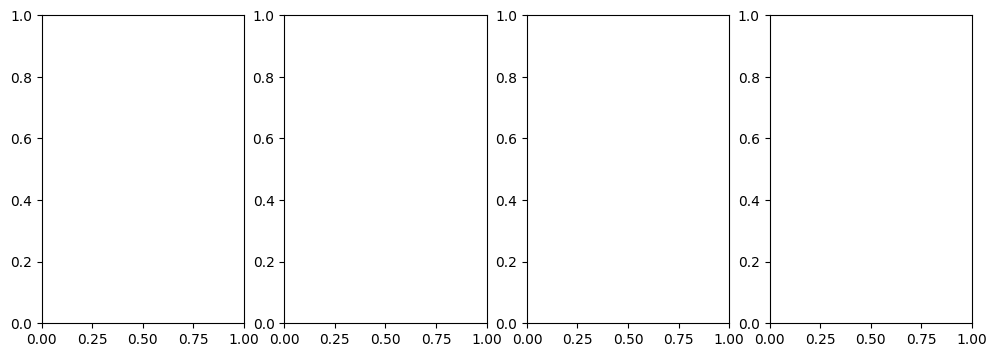

In [8]:
print('Predicted values: ')
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for ax, image, prediction in zip(axes, data.x_image_test, predicted):
    ax.set_axis_off()
    image = image.reshape(data.resized_images_width, data.resized_images_height)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f'{prediction}')

Classification report for classifier RandomForestClassifier(n_jobs=-1):
                              precision    recall  f1-score   support

             Acer_Capillipes       0.67      1.00      0.80         2
             Acer_Circinatum       0.50      1.00      0.67         2
                   Acer_Mono       1.00      1.00      1.00         2
                 Acer_Opalus       0.50      0.50      0.50         2
               Acer_Palmatum       1.00      1.00      1.00         2
                 Acer_Pictum       1.00      1.00      1.00         2
             Acer_Platanoids       1.00      1.00      1.00         2
                 Acer_Rubrum       0.33      0.50      0.40         2
              Acer_Rufinerve       0.67      1.00      0.80         2
            Acer_Saccharinum       0.00      0.00      0.00         2
               Alnus_Cordata       1.00      1.00      1.00         2
          Alnus_Maximowiczii       0.33      0.50      0.40         2
                 

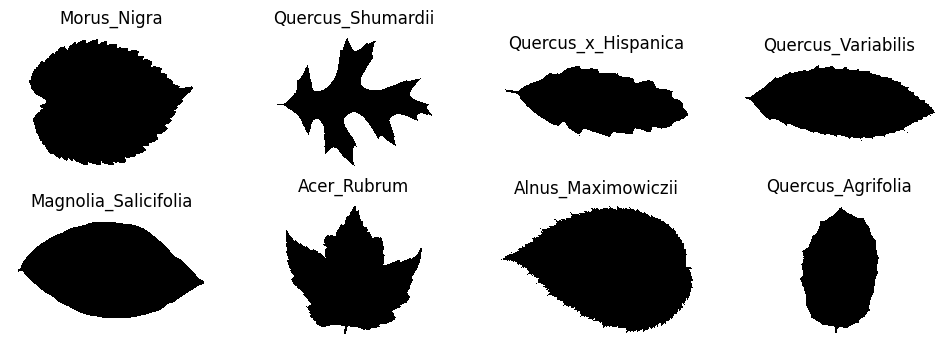

In [11]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(data.y_image_test, predicted)}\n"
)

report = metrics.classification_report(data.y_image_test, predicted, output_dict=True)
df = pd.DataFrame(report).transpose()
# Some targets are missing in the test set and due to this fact, the precision and recall are replaced by 0.
# So, we will remove them from the report.
df = df[df['f1-score'] != 0]

# Then, we keep the 10 leaf species with the worst f1-score.
worst_leaf_names = df.sort_values(by=['f1-score'], ascending=True)[:10].index.values

worst_leaf_indexes = [np.where(data.y_tab == name)[0][0] for name in worst_leaf_names]
worst_images = [data.x_image_tab[i] for i in worst_leaf_indexes]
worst_labels = [data.y_tab[i] for i in worst_leaf_indexes]

print('The leaf species with the worst f1-score are the following: ')
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 4))
for ax, image, label in zip(axes.flatten(), worst_images, worst_labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f'{label}')